In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((192, 4))

In [3]:
mice.setup_func_data()

In [4]:
from sklearn.decomposition import PCA

def make_pca_fig(data, mask, name):
    x = data[mask]
    pca = PCA(n_components=100, svd_solver='auto').fit(x)
    
    fig1, axes1 = create_figure(1, 2, (13, 3.5), gridspec_kw={'width_ratios': [1, 3]})

    var_ratio = pca.explained_variance_ratio_ * 100
    axes1[0].plot(var_ratio, label='variance_ratio')
    axes1[0].plot(np.cumsum(var_ratio), label='variance_cumulative')
    axes1[0].legend()
    axes1[0].grid()
    axes1[0].set_title('variance explained')

    axes1[1].plot(pca.components_[0])
    axes1[1].grid()
    axes1[1].set_title('1st PC loading')

    sup1 = fig1.suptitle(f"{key}, PCA using {name} data", fontsize=15, y=1.03)
    plt.close()
    
    y = np.zeros((*data.shape[:2], pca.n_components))
    y[mask] = pca.transform(x)
    y_tr, mask_tr = filter_boundaries([y, mask], mask)
    data2plt = np.ma.masked_where(~np.repeat(np.expand_dims(mask_tr, -1), pca.n_components, -1), y_tr)

    fig2, axes2 = create_figure(10, 10, (13.5, 17), 'all', 'all')
    for i, ax in enumerate(axes2.flat):
        ax.imshow(data2plt[..., i], cmap='icefire')
        ax.set_title(f"PC_{i}, {var_ratio[i]:0.1f}%")
    sup2 = fig2.suptitle(f"{key}, PCs for {name} data", fontsize=15, y=1.03)
    _ = remove_ticks(axes2)
    plt.close()
    
    return (fig1, fig2), (axes1, axes2), (sup1, sup2)

In [ ]:
figs = collections.defaultdict(list)
sups = collections.defaultdict(list)

for key, func in tqdm(mice.ca.items()):
    sub, ses, run = mice.looper[key]

    #if key not in ['sub-SLC03_ses-1_run-1']:
    #    continue

    fig, axes = create_figure(3, 1, (13, 7.5), 'all', 'none')
    
    sz = 0
    part_sizes = []
    raw_indiv = []
    for i in range(1, 4):
        part_file = f"sub-SLC{sub:02d}_ses-{ses}_task-rest_run-{run}_part-{i}_space-individual_desc-preproc_ca2.nii.gz"
        try:
            img = nib.load(pjoin(mice.cfg.raw_dir, part_file))
            x = img.get_fdata().squeeze()
            raw_indiv.append(x)
            sz += x.shape[-1]
            part_sizes.append(sz)
        except FileNotFoundError:
            print(f"warning: {key} . . . part {i}, file not found")
        
    try:
        raw_indiv = np.concatenate(raw_indiv, axis=-1)
        raw_indiv_mask = np.abs(raw_indiv).mean(-1) > 0
    except ValueError:
        raw_indiv = None
    
    if raw_indiv is not None:
        axes[0].plot(range(0, raw_indiv.shape[-1]), raw_indiv[raw_indiv_mask].mean(0))
        axes[0].plot(range(500, raw_indiv.shape[-1]), raw_indiv[raw_indiv_mask].mean(0)[500:])
        for sz in part_sizes[:-1]:
            axes[0].axvline(sz, color='k', ls='--', lw=0.8)

    common_file = f"sub-SLC{sub:02d}_ses-{ses}_task-rest_run-{run}_space-common_desc-preproc_ca2.nii.gz"
    try:
        common = nib.load(pjoin(mice.cfg.raw_dir, common_file))
        common = common.get_fdata().squeeze()
        common_mask = np.abs(common).mean(-1) > 0
    except FileNotFoundError:
        print(f"warning: {key} . . . common file not found")
        common = None
    
    if common is not None:
        axes[1].plot(range(0, common.shape[-1]), common[common_mask].mean(0))
        axes[1].plot(range(500, common.shape[-1]), common[common_mask].mean(0)[500:])
    
    data = func.get_data()
    axes[2].plot(range(500, data.shape[-1] + 500), np.nanmean(data, 0))
    
    for ax in axes.flat:
        ax.set(xticks=np.linspace(0, 6000, 13))
        ax.grid()
    
    axes[0].set_ylabel('preproc (3 parts)')
    axes[1].set_ylabel('time series -> common\n(bandpassed)')
    axes[2].set_ylabel('labels -> common\n(no bandpass)')
    sup = fig.suptitle(key, fontsize=17, y=1.01)
    
    plt.close()
    
    figs['mean'].append(fig)
    sups['mean'].append(sup)
    
    if common is not None:
        (fig1, fig2), _, (sup1, sup2) = make_pca_fig(common, common_mask, 'common')
        figs['PCA_common_1'].append(fig1)
        figs['PCA_common_2'].append(fig2)
        sups['PCA_common_1'].append(sup1)
        sups['PCA_common_2'].append(sup2)

    if raw_indiv is not None:
        (fig1, fig2), _, (sup1, sup2) = make_pca_fig(raw_indiv, raw_indiv_mask, 'raw indiv')
        figs['PCA_indiv_1'].append(fig1)
        figs['PCA_indiv_2'].append(fig2)
        sups['PCA_indiv_1'].append(sup1)
        sups['PCA_indiv_2'].append(sup2)

  0%|          | 0/162 [00:00<?, ?it/s]

warning: sub-SLC03_ses-1_run-1 . . . part 3, file not found

warning: sub-SLC03_ses-1_run-1 . . . common file not found

warning: sub-SLC03_ses-2_run-1 . . . common file not found

In [ ]:
list(figs)

In [ ]:
for item in figs:
    file = f"ca_quality_fig_{item}.pdf"
    file = pjoin(tmp_dir, file)
    save_fig(figs[item], sups[item], save_file=file, display=False, multi=True)

In [13]:
part_file

'sub-SLC-1_ses-3_task-rest_run--1_part-3_space-individual_desc-preproc_ca2.nii.gz'

In [112]:
import fnmatch

In [113]:
key = 'sub-SLC01_ses-2_run-5'
kw = 'sub-SLC01_ses-2_task-rest_run-5'

files = fnmatch.filter(
    os.listdir(mice.cfg.raw_dir),
    f"{kw}*_desc-preproc_ca2.nii.gz",
)
files = sorted(files)

In [10]:
sub, ses, run = 1, 1, 5



In [11]:
part_file
common_file

'sub-SLC01_ses-1_task-rest_run-5_part-3_space-common_desc-preproc_ca2.nii.gz'

In [114]:
files

[
    'sub-SLC01_ses-2_task-rest_run-5_part-1_space-individual_desc-preproc_ca2.nii.gz',
    'sub-SLC01_ses-2_task-rest_run-5_part-2_space-individual_desc-preproc_ca2.nii.gz',
    'sub-SLC01_ses-2_task-rest_run-5_part-3_space-individual_desc-preproc_ca2.nii.gz',
    'sub-SLC01_ses-2_task-rest_run-5_space-common_desc-preproc_ca2.nii.gz'
]

In [115]:
f = files[0]
print(f)
img = nib.load(pjoin(mice.cfg.raw_dir, f))
data1 = img.get_fdata().squeeze()

f = files[1]
print(f)
img = nib.load(pjoin(mice.cfg.raw_dir, f))
data2 = img.get_fdata().squeeze()

f = files[2]
print(f)
img = nib.load(pjoin(mice.cfg.raw_dir, f))
data3 = img.get_fdata().squeeze()

sub-SLC01_ses-2_task-rest_run-5_part-1_space-individual_desc-preproc_ca2.nii.gz

sub-SLC01_ses-2_task-rest_run-5_part-2_space-individual_desc-preproc_ca2.nii.gz

sub-SLC01_ses-2_task-rest_run-5_part-3_space-individual_desc-preproc_ca2.nii.gz

In [116]:
data_cat = np.concatenate([data1, data2, data3], axis=-1)

In [117]:
data1.shape, data2.shape, data3.shape, data_cat.shape

((256, 250, 2090), (256, 250, 2089), (256, 250, 1821), (256, 250, 6000))

<matplotlib.image.AxesImage object at 0x7fd44cf35a00>

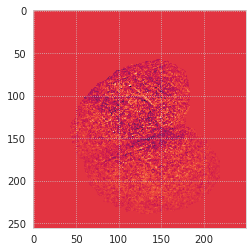

In [118]:
plt.imshow(data_cat[..., 500 + 1070])

<matplotlib.image.AxesImage object at 0x7fd44ce8d250>

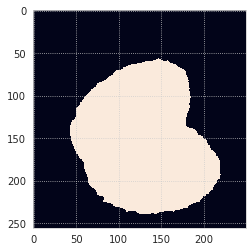

In [119]:
mask = np.abs(data_cat).mean(-1) > 0
plt.imshow(mask)

[<matplotlib.lines.Line2D object at 0x7fd44ce623d0>]

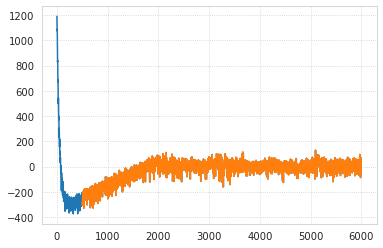

In [120]:
plt.plot(range(0, data_cat.shape[-1]), data_cat[mask].mean(0))
plt.plot(range(500, data_cat.shape[-1]), data_cat[mask].mean(0)[500:])

In [121]:
data_me = mice.ca[key].get_data()
data_me.shape

(302, 5500)

[<matplotlib.lines.Line2D object at 0x7fd44ce32d90>]

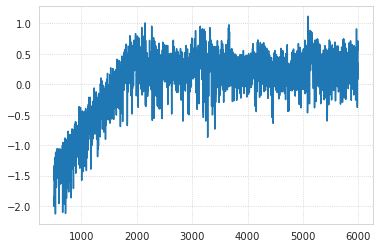

In [123]:
f = files[-1]
print(f)
common = nib.load(pjoin(mice.cfg.raw_dir, f))
data = common.get_fdata().squeeze()
data.shape

sub-SLC01_ses-2_task-rest_run-5_space-common_desc-preproc_ca2.nii.gz

(118, 160, 6000)

<matplotlib.image.AxesImage object at 0x7fd44cd95070>

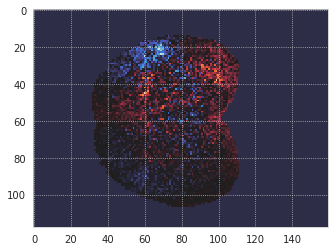

In [124]:
plt.imshow(data[..., 500 + 200], cmap='icefire')

<matplotlib.image.AxesImage object at 0x7fd44e66f160>

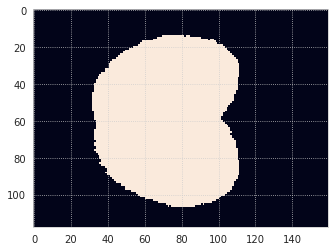

In [125]:
mask = np.abs(data).sum(-1).astype(bool)
plt.imshow(mask)

[<matplotlib.lines.Line2D object at 0x7fd44d2dca00>]

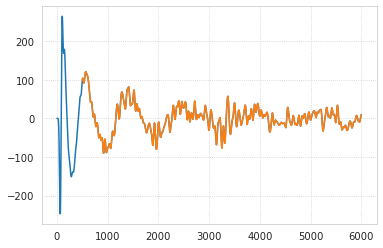

In [126]:
plt.plot(range(0, data.shape[-1]), data[mask].mean(0))
plt.plot(range(500, data.shape[-1]), data[mask].mean(0)[500:])

In [4]:
func = mice.ca['sub-SLC07_ses-2_run-5']
a, p = sp_stats.spearmanr(func.get_data(), axis=1)

In [7]:
a[np.isnan(a)] = 0.
p[np.isnan(p)] = 1.
a[p >= 0.05] = 0.

In [8]:
a.shape

(302, 302)

<matplotlib.image.AxesImage object at 0x7fecc26a20a0>

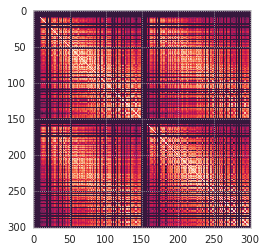

In [9]:
plt.imshow(a)

In [15]:
np.where(np.abs(a - a.T).sum(0) > 0)[0]

array([ 10,  11,  13,  14,  15,  16,  17,  21,  25,  27,  31,  32,  34,
        36,  38,  39,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,
        54,  55,  56,  57,  59,  60,  61,  63,  65,  66,  67,  68,  70,
        75,  79,  80,  81,  82,  84,  85,  86,  88,  90,  92,  96,  97,
        99, 102, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116,
       118, 119, 120, 121, 124, 125, 128, 129, 131, 132, 133, 134, 136,
       137, 138, 139, 140, 144, 145, 146, 147, 148, 158, 161, 162, 164,
       166, 167, 168, 169, 172, 176, 177, 178, 179, 180, 181, 182, 183,
       185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 215,
       216, 217, 218, 219, 220, 221, 223, 225, 226, 227, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 239, 240, 241, 243, 245, 247, 249,
       252, 253, 257, 258, 259, 261, 262, 265, 266, 267, 271, 272, 275,
       277, 279, 282, 283, 287, 289, 290, 291, 292, 294, 295, 296, 297,
       298])

In [17]:
np.where(np.abs(a).sum(0) == 0)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  18,  20,
        22,  24,  30,  35,  40,  51,  53,  62,  77,  87,  91,  93,  95,
       100, 110, 112, 117, 122, 126, 135, 142, 150, 151, 152, 153, 154,
       155, 156, 157, 159, 160, 163, 171, 173, 175, 228, 238, 244, 251,
       254, 256, 263, 268, 273, 281, 284, 286, 288, 293, 299, 301])

[<matplotlib.lines.Line2D object at 0x7fecc1418a60>]

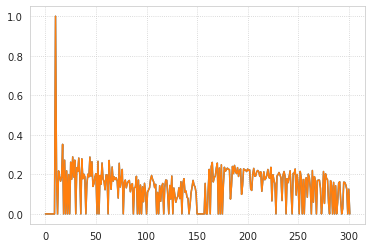

In [20]:
plt.plot(a[10])
plt.plot(a.T[10])

In [21]:
np.where(np.abs(a[10] - a.T[10]) > 0)

(
    array([ 13,  15,  16,  31,  32,  34,  38,  42,  43,  54,  55,  57,  59,
        60,  63,  65,  66,  67,  75,  82,  84,  86,  88,  97,  99, 103,
       104, 107, 108, 111, 115, 120, 124, 128, 129, 131, 133, 138, 139,
       140, 145, 147, 166, 167, 169, 176, 179, 181, 182, 185, 187, 188,
       189, 190, 191, 192, 195, 196, 198, 199, 203, 205, 207, 208, 209,
       210, 211, 212, 213, 218, 229, 230, 231, 232, 237, 239, 240, 241,
       245, 247, 249, 257, 259, 261, 267, 275, 277, 279, 282, 291, 298]),
)

In [23]:
a[10, 13], a[13, 10]

(0.21760498914427234, 0.21760498914427231)

<matplotlib.colorbar.Colorbar object at 0x7fec6805fe20>

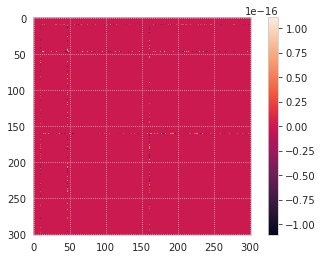

In [24]:
plt.imshow(a - a.T)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7fec681462e0>

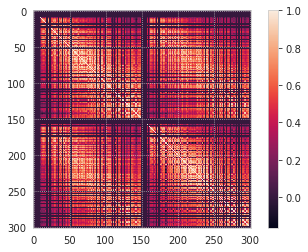

In [27]:
plt.imshow(b)
plt.colorbar()

In [28]:
(np.abs(a - b)).sum()

1.0283440765590512e-14

In [11]:
y = sp_dist.squareform(1 - a)

ValueError: Distance matrix 'X' must be symmetric.

In [29]:
percentiles = [5, 10, 15, 20, 30, 40]
percentiles = sorted(percentiles, reverse=True)

In [30]:
net = Network(mice, 'sub-SLC07_ses-2_run-5', 'ca2', 'rest', percentiles=percentiles)

In [31]:
_ = net.load_network()

In [36]:
(net.adj != (net.adj + net.adj.T) / 2).sum()

0

In [212]:
net.percentiles

[40, 30, 20, 15, 10, 5]

<matplotlib.image.AxesImage object at 0x7fe68ae82d60>

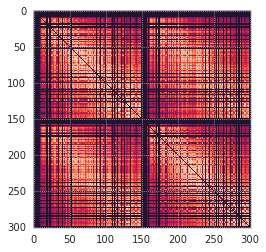

In [213]:
plt.imshow(net.adj)

In [214]:
net.data.shape

(302, 5500)

In [215]:
name = 'parcel2d-top'
reg_k = f"region-idxs_{name}"
nonzero_k = f"nonzero-idxs_{name}"

arr = np.zeros(mice.parcel[f"shape_{name}"] + (net.data.shape[-1],))

for t in tqdm(range(net.data.shape[-1])):
    if t > 1000 or t < 900:
        continue
    for node, lbl in net.n2l.items():
        ii = mice.parcel.encode(lbl)
        if ii in mice.parcel[reg_k]:
            ids = mice.parcel[reg_k][ii]
            ids = mice.parcel[nonzero_k][ids]
            arr[..., t].flat[ids] = net.data[node, t]

  0%|          | 0/5500 [00:00<?, ?it/s]

In [216]:
arr.shape

(1320, 1140, 5500)

In [217]:
xxx = arr[..., 900:1000]
np.nanmax(np.abs(xxx))

5.117308042719947

In [218]:
import ants

topview = 'topview_10um.nii.gz'
topview = pjoin(mice.cfg.base_dir, topview)
topview = ants.image_read(topview, pixeltype='unsigned int')
topview = topview.numpy()

flatmap = 'flatmap_10um.nii.gz'
flatmap = pjoin(mice.cfg.base_dir, flatmap)
flatmap = ants.image_read(flatmap, pixeltype='unsigned int')
flatmap = flatmap.numpy()

<matplotlib.colorbar.Colorbar object at 0x7fe68ad12940>

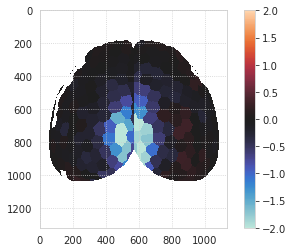

In [224]:
data2plt = xxx[..., 29]
# vminmax = np.nanmax(np.abs(data2plt))
data2plt = np.ma.masked_where(topview == 0, data2plt)
plt.imshow(data2plt, cmap='icefire', vmin=-2, vmax=2)
plt.colorbar()

[<matplotlib.lines.Line2D object at 0x7fe68a8571f0>]

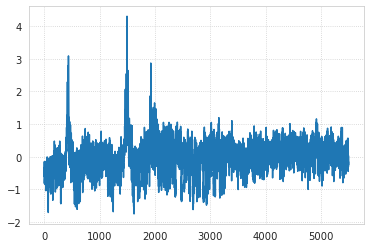

In [233]:
net.data[:, 100:9000].mean(0).shape

(5400,)

In [6]:
net.load_network()

<analysis.network.Network object at 0x7f11e1f02550>

<matplotlib.colorbar.Colorbar object at 0x7f11e20c2c10>

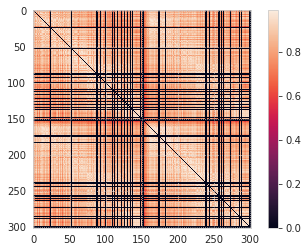

In [7]:
plt.imshow(net.adj)
plt.colorbar()

In [8]:
net.percentiles

[40, 30, 20, 15, 10, 5, 0]

In [9]:
net.thresholds

{
    40: 0.8525387221262998,
    30: 0.8755276277781043,
    20: 0.8994336017642965,
    15: 0.9123160348129686,
    10: 0.9262134833766494,
    5: 0.9435525234977404,
    0: 0.9895056331776114
}

<AxesSubplot:ylabel='Count'>

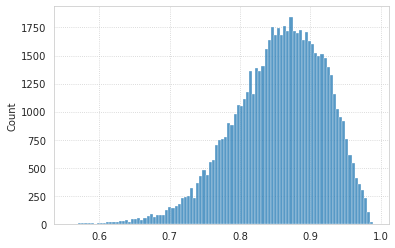

In [10]:
sns.histplot(net.adj[net.adj.nonzero()])

In [11]:
net._nonneg_perc()

100

In [ ]:
n-192*4_ca2_rest_pearson_

In [7]:
mice.setup_func_data('all')

In [9]:
ca

{
    'sub-SLC01_ses-1_run-1': <model.dataset.FuncData object at 0x7f705134fee0>,
    'sub-SLC01_ses-1_run-3': <model.dataset.FuncData object at 0x7f705134ff10>,
    'sub-SLC01_ses-1_run-5': <model.dataset.FuncData object at 0x7f7051353100>,
    'sub-SLC01_ses-1_run-7': <model.dataset.FuncData object at 0x7f7051353190>,
    'sub-SLC01_ses-2_run-1': <model.dataset.FuncData object at 0x7f7050564910>,
    'sub-SLC01_ses-2_run-3': <model.dataset.FuncData object at 0x7f7050564970>,
    'sub-SLC01_ses-2_run-5': <model.dataset.FuncData object at 0x7f7050564bb0>,
    'sub-SLC01_ses-2_run-7': <model.dataset.FuncData object at 0x7f7050564f10>,
    'sub-SLC01_ses-3_run-1': <model.dataset.FuncData object at 0x7f705131f280>,
    'sub-SLC01_ses-3_run-3': <model.dataset.FuncData object at 0x7f705131f490>,
    'sub-SLC01_ses-3_run-5': <model.dataset.FuncData object at 0x7f705131f670>,
    'sub-SLC01_ses-3_run-7': <model.dataset.FuncData object at 0x7f705131f910>,
    'sub-SLC02_ses-1_run-1': <model.dataset.FuncData object at 0x7f705131fcd0>,
    'sub-SLC02_ses-1_run-3': <model.dataset.FuncData object at 0x7f705131ff10>,
    'sub-SLC02_ses-1_run-5': <model.dataset.FuncData object at 0x7f705131fd30>,
    'sub-SLC02_ses-1_run-7': <model.dataset.FuncData object at 0x7f7051212310>,
    'sub-SLC02_ses-2_run-1': <model.dataset.FuncData object at 0x7f7051212730>,
    'sub-SLC02_ses-2_run-3': <model.dataset.FuncData object at 0x7f7051212970>,
    'sub-SLC02_ses-2_run-5': <model.dataset.FuncData object at 0x7f7051212af0>,
    'sub-SLC02_ses-3_run-1': <model.dataset.FuncData object at 0x7f705131f850>,
    'sub-SLC02_ses-3_run-3': <model.dataset.FuncData object at 0x7f705131faf0>,
    'sub-SLC02_ses-3_run-5': <model.dataset.FuncData object at 0x7f705131f250>,
    'sub-SLC02_ses-3_run-7': <model.dataset.FuncData object at 0x7f705131f220>,
    'sub-SLC03_ses-1_run-1': <model.dataset.FuncData object at 0x7f70513530a0>,
    'sub-SLC03_ses-1_run-2': <model.dataset.FuncData object at 0x7f70513530d0>,
    'sub-SLC03_ses-1_run-4': <model.dataset.FuncData object at 0x7f705134ff40>,
    'sub-SLC03_ses-1_run-6': <model.dataset.FuncData object at 0x7f7050564640>,
    'sub-SLC03_ses-2_run-1': <model.dataset.FuncData object at 0x7f7051212e20>,
    'sub-SLC03_ses-2_run-3': <model.dataset.FuncData object at 0x7f7051212850>,
    'sub-SLC03_ses-2_run-5': <model.dataset.FuncData object at 0x7f7051212100>,
    'sub-SLC03_ses-2_run-7': <model.dataset.FuncData object at 0x7f70512122e0>,
    'sub-SLC03_ses-3_run-1': <model.dataset.FuncData object at 0x7f70512121f0>,
    'sub-SLC03_ses-3_run-3': <model.dataset.FuncData object at 0x7f70512263d0>,
    'sub-SLC03_ses-3_run-5': <model.dataset.FuncData object at 0x7f70512265b0>,
    'sub-SLC03_ses-3_run-7': <model.dataset.FuncData object at 0x7f7051226850>,
    'sub-SLC04_ses-1_run-1': <model.dataset.FuncData object at 0x7f7051226c10>,
    'sub-SLC04_ses-1_run-3': <model.dataset.FuncData object at 0x7f7051226e50>,
    'sub-SLC04_ses-1_run-5': <model.dataset.FuncData object at 0x7f7051226c70>,
    'sub-SLC04_ses-1_run-7': <model.dataset.FuncData object at 0x7f7051242250>,
    'sub-SLC04_ses-2_run-1': <model.dataset.FuncData object at 0x7f70512269a0>,
    'sub-SLC04_ses-2_run-3': <model.dataset.FuncData object at 0x7f7051226f40>,
    'sub-SLC04_ses-2_run-5': <model.dataset.FuncData object at 0x7f7051226310>,
    'sub-SLC04_ses-2_run-7': <model.dataset.FuncData object at 0x7f7051226130>,
    'sub-SLC04_ses-3_run-1': <model.dataset.FuncData object at 0x7f705134ffd0>,
    'sub-SLC04_ses-3_run-3': <model.dataset.FuncData object at 0x7f70512260d0>,
    'sub-SLC04_ses-3_run-5': <model.dataset.FuncData object at 0x7f70512129a0>,
    'sub-SLC04_ses-3_run-7': <model.dataset.FuncData object at 0x7f7051212eb0>,
    'sub-SLC05_ses-1_run-1': <model.dataset.FuncData object at 0x7f70505648b0>,
    'sub-SLC05_ses-1_run-3': <model.dataset.FuncData object at 0x7f7050564550>,
    'sub-SLC05_ses-1_run-5': <model.dataset.FuncData object at 0x7f705131fd00>

In [3]:
net = Network(mice, 'sub-SLC06_ses-1', 'bold', 'rest')

In [4]:
net.fit_network(save=False)

[PROGRESS] fit: initiated

[PROGRESS] graphs: done

[PROGRESS] fit: done!

<analysis.network.Network object at 0x7f523db57220>

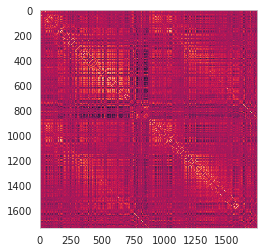

In [6]:
plt.imshow(net.adj)
plt.grid()